In [145]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [147]:
time_slot = 5*60*1000 # 5 seconds
length = 10 # number of timeslots around
embedded_size = 30
N = 7

In [148]:
DATA_PATH = '/content/gdrive/MyDrive/NCKH/IoT/dataset_17-02-2022.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/IoT/v5_attention.hdf5'

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

In [149]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)
df['timestamp'] = list(map(lambda x: int(datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()),df['timestamp']))
df.head(10)

,sensor,value,timestamp
0,O3,0.20565482974052,1594028407
1,NO2,0,1594028407
2,CO,0.23644705116749,1594028407
3,PRES,100276.1875,1594028407
4,HUM,49.6015625,1594028407
5,TC,25.5,1594028407
6,BAT,58,1594028407
7,O3,0.20122393965721,1594030208
8,NO2,0,1594030208
9,CO,0.16477552056313,1594030208


In [150]:
lst_sensor = list(set(df['sensor']))
lst_sensor.remove('WV')
len(lst_sensor)

16

In [151]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1594027700, 1623141813, 98)

In [152]:
import more_itertools as mit

X_idx = []
y = []

maximum_value = {}
start_end = {}
normalized_df = pd.DataFrame(columns=df.columns)

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]
  history = subdf.value.astype(np.float32)
  history[history < 0] = 0
  maximum_value[sensor] = np.max(history)
  y.extend(history[N:]/maximum_value[sensor])
  history = (history/maximum_value[sensor] * 100).astype(int)
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  
  subdf.value = history
  normalized_df = normalized_df.append(subdf)

df = normalized_df
X = np.array(X_idx)
y = np.array(y)
X.shape, y.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


((486340, 7), (486340,))

In [153]:
maximum_value

{'ANE': 40.79999923706055,
 'B': 45.0,
 'BAT': 100.0,
 'CO': 11.349579811096191,
 'HUM': 100.0,
 'LUX': 21010.0,
 'NO2': 0.17887425422668457,
 'NOISE': 73.00460052490234,
 'O3': 0.4146099388599396,
 'PLV1': 107.56999969482422,
 'PLV2': 46.380001068115234,
 'PLV3': 102.54000091552734,
 'PM10': 10.100000381469727,
 'PM25': 8.800000190734863,
 'PRES': 100939.109375,
 'TC': 43.7599983215332}

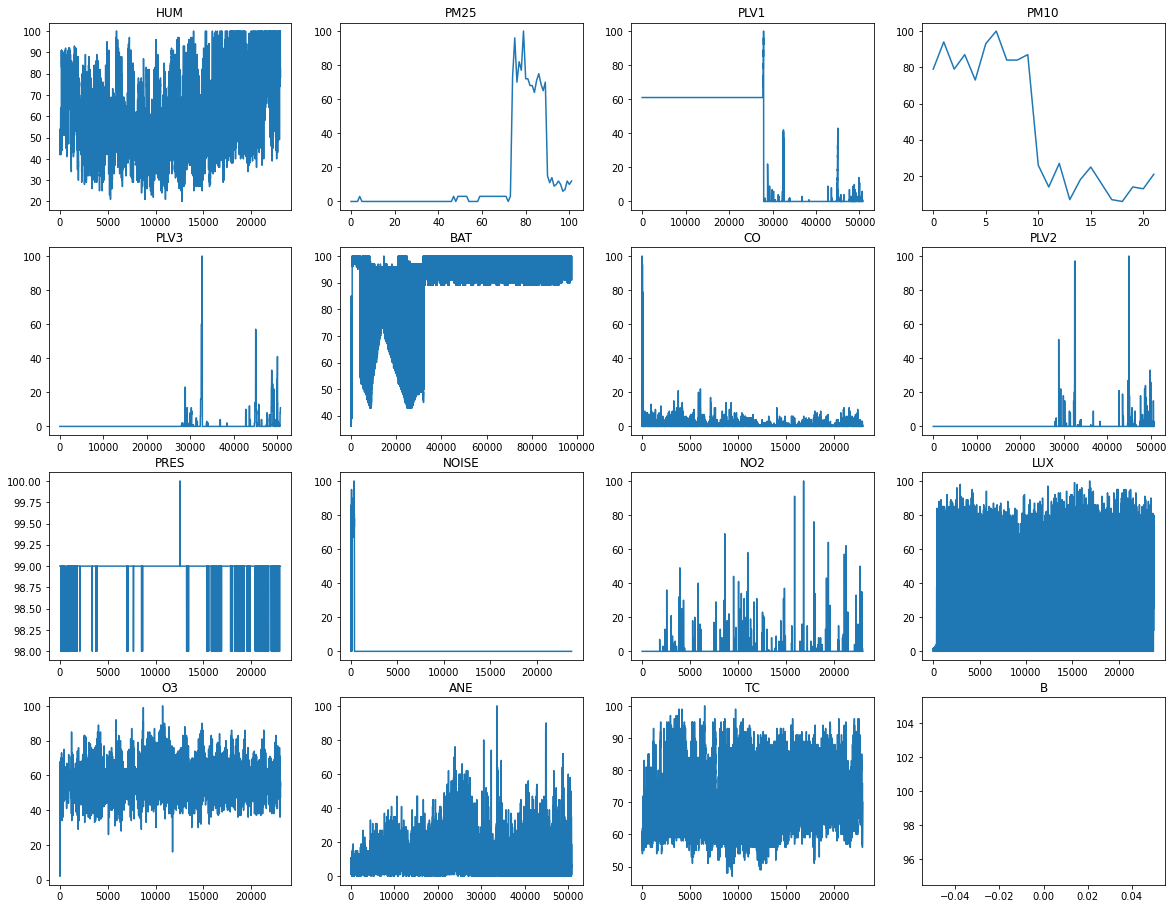

In [154]:
from matplotlib import pyplot as plt

f = plt.figure(figsize=(20,20))

for i,sensor in enumerate(lst_sensor,start=1):
    yy = df[df.sensor==sensor].value
    xx = range(len(yy))
    
    f.add_subplot(5,4,i)
    plt.plot(xx,yy)
    plt.title(sensor)

### generate

In [155]:
len(lst_sensor)

16

In [156]:
import more_itertools as mit
from google.colab import output
from functools import reduce
X_item2vec = []
# X = []
# y = []

#is_exists = np.zeros(num_of_items,)

def onehot(x):
  #x: int
  lst = [0]*100
  lst[x] = 1
  return lst

def removeNul(x):
  #(1,2,-1,3,-1,2) -> (1,2,3,2)
  res = []
  return [str(i) for i in x if (i != -1)]

def flatten(x):
  #[[1],[2,1,3],[2]] -> [1,2,1,3,2]
  return [str(i) for c in x for i in c]

all_values = set()

for sensor in lst_sensor:
  subdf = df[df.sensor == sensor]

  # train_data for Item2Vec
  idx = ((subdf.timestamp - start_time) // time_slot).to_numpy()[:-1]
  values = subdf.value
  series = [[] for _ in range(num_of_slots)]
  for id,value in zip(idx,values):
    series[id].append(value)

  temp = list(mit.windowed(series, n=length, step=1))[:-1]  
  new_row = list(map(flatten,temp))
  X_item2vec.extend(new_row)
  
  for i in new_row: 
    all_values = all_values.union(i)


  # data for MLP
  # history = list(map(lambda x: hash_itemID[x],subdf.itemID))
  # new_x = list(mit.windowed(history, n=N, step=1))[:-1]
  # X.extend(new_x)
  # y.extend(list(map(onehot,history[N:])))

  # sensor = 'ANE'
  # X = np.array(X[start_end[sensor][0]:start_end[sensor][1]])
  # y = np.array(y[start_end[sensor][0]:start_end[sensor][1]])
  # y = y/100
  # X.shape, y.shape

In [157]:
#######################################
# CHECK IF THIS VALUE IS EQUAL TO 101 #
#######################################
len(all_values)

101

In [158]:
from gensim.models import Word2Vec
#CBOW model
vecs = Word2Vec(X_item2vec, min_count=1, size=embedded_size, window=5, sg=0)

In [159]:
vecs['31']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.62519944, -0.0859971 ,  0.52970815, -1.6337148 , -1.5914218 ,
       -0.44380805,  0.06143768, -1.758271  , -2.8834999 , -0.8387132 ,
        1.8819264 ,  0.40167585, -2.5238028 , -1.3441972 , -2.470607  ,
       -0.85631317,  0.37745944, -0.43028736,  0.8669367 ,  1.1280941 ,
        0.76021016,  0.989629  , -1.1273884 , -0.26448074,  2.666905  ,
       -1.4863865 ,  2.2061012 ,  0.46511862,  0.9475038 , -2.5512977 ],
      dtype=float32)

In [160]:
vecs.similar_by_vector(vecs['31'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('31', 1.0),
 ('32', 0.8780270218849182),
 ('29', 0.837812602519989),
 ('30', 0.7993260025978088),
 ('33', 0.7813440561294556),
 ('34', 0.754168689250946),
 ('35', 0.6827501058578491),
 ('28', 0.6432384252548218),
 ('27', 0.6302995681762695),
 ('25', 0.6159753203392029)]

#### split train-test

In [161]:
def mapping(x):
  #x = (1,2,3) -> (vect(1),vect(2),vect(3))
  return [vecs[str(i)] for i in x]

In [162]:
X = np.array(list(map(mapping,X)))
y = np.array(y)
y = y.reshape(len(y), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [163]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [164]:
print(X_train[0],y_train[0],sep='\n\n')

[[ 1.6374724   1.3290287   1.1352075  -0.42592543 -2.4022703  -4.9233108
  -1.0498428  -0.5665285  -0.50569916  0.6019671  -0.65468156  3.9315221
   2.0328004   2.7292821  -0.22997819  1.2962208   2.5522885  -4.1978364
  -0.54400086  2.7109923  -3.1246638  -1.3720623  -2.8787196   0.26668778
   1.0349902   1.6531489   0.70127547 -1.8374974   0.82347685  1.1858327 ]
 [ 1.6374724   1.3290287   1.1352075  -0.42592543 -2.4022703  -4.9233108
  -1.0498428  -0.5665285  -0.50569916  0.6019671  -0.65468156  3.9315221
   2.0328004   2.7292821  -0.22997819  1.2962208   2.5522885  -4.1978364
  -0.54400086  2.7109923  -3.1246638  -1.3720623  -2.8787196   0.26668778
   1.0349902   1.6531489   0.70127547 -1.8374974   0.82347685  1.1858327 ]
 [ 1.6374724   1.3290287   1.1352075  -0.42592543 -2.4022703  -4.9233108
  -1.0498428  -0.5665285  -0.50569916  0.6019671  -0.65468156  3.9315221
   2.0328004   2.7292821  -0.22997819  1.2962208   2.5522885  -4.1978364
  -0.54400086  2.7109923  -3.1246638  -1.3720

In [165]:
X_train.shape, y_train.shape

((340438, 7, 30), (340438, 1))

# MLP

In [166]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import tensorflow as tf 
from sklearn.metrics import mean_squared_error


input_raw = Input((N,embedded_size))

lstm = LSTM(64, return_sequences=True, dropout=0.5)(input_raw) #64 is number of cells
lstm,state_h,state_c = LSTM(64, return_sequences=True, return_state=True, dropout=0.5)(lstm)

score = Dot(-1)([lstm,state_h])
softmax = Softmax()(score)
sm_reshape = Reshape(target_shape=(-1,1,))(softmax)
mul = Multiply()([lstm,sm_reshape])
context = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(mul)
concat = Concatenate()([context, state_h])
attention = Dense(20, activation='tanh')(concat)
attention = Dropout(0.5)(attention)
flatten = Flatten()(attention)


y_pred = Dense(1, activation='sigmoid')(flatten)

model = Model(inputs = input_raw, outputs = y_pred)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 7, 30)]      0           []                               
                                                                                                  
 lstm_8 (LSTM)                  (None, 7, 64)        24320       ['input_5[0][0]']                
                                                                                                  
 lstm_9 (LSTM)                  [(None, 7, 64),      33024       ['lstm_8[0][0]']                 
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [167]:
lrate = 1e-4
opt = tf.keras.optimizers.Adam(learning_rate=lrate)
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(optimizer=opt, loss=root_mean_squared_error, metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=10, monitor='loss')
history = model.fit(X_train,y_train,batch_size=125,epochs=1000,verbose=True, callbacks=[early_stop,model_checkpoint])

Epoch 1/1000
2724/2724 [==============================] - 32s 10ms/step - loss: 0.0735 - accuracy: 0.4191
Epoch 2/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0571 - accuracy: 0.4199
Epoch 3/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0545 - accuracy: 0.4199
Epoch 4/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0535 - accuracy: 0.4199
Epoch 5/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0524 - accuracy: 0.4199
Epoch 6/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0517 - accuracy: 0.4198
Epoch 7/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0512 - accuracy: 0.4198
Epoch 8/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0507 - accuracy: 0.4199
Epoch 9/1000
2724/2724 [==============================] - 28s 10ms/step - loss: 0.0501 - accuracy: 0.4199
Epoch 10/1000
2724/2724 [=====================

In [ ]:
model.save_weights(WEIGHTS_PATH)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.title('lrate='+str(lrate), pad=-50)

In [ ]:
model.load_weights(WEIGHTS_PATH)

In [ ]:
rmse_model = model.evaluate(X_test, y_test)
print("Mean Square Error of Model = {}".format(rmse_model))

In [ ]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred,y_test)

print("RMSE of testset = {}".format(rmse))
print(math.sqrt(mean_squared_error(y_pred, y_test)))

In [ ]:
def plot(y_true,y_pred):
  ar = range(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

In [ ]:
plot(y_test[:200], y_pred[:200])

In [ ]:
#wrapper
def process(sensor, inp):
  #sensor: sensor id
  #x: array/ndarray of N value in the past
  inp = (np.array(inp)/maximum_value[sensor]*100).astype(int)
  inp = np.array([vecs[str(i)] for i in inp])
  out = model.predict(np.array([inp]))
  out = out*maximum_value[sensor]

  return out[0][0]

## Infer

In [ ]:
df = pd.read_csv(DATA_PATH)
df = df.drop(['id','id_wasp','id_secret','frame_type','frame_number','sync','raw','parser_type','MeshliumID'],axis=1)

idx = 33586
arr = df[df.sensor=='ANE'].value.to_numpy().astype(np.float32)
print("SAMPLE INPUT: ",end='')
print(', '.join(arr[idx:idx+N].astype(str)))
print("EXPECT: ",end='')
print(arr[idx+N])

In [ ]:
process('ANE',arr[idx:idx+N])